# Seizure visualization sandbox

This notebook provides a comprehensive analysis and visualization pipeline for seizure detection and spread analysis. It processes iEEG data, applies machine learning models for seizure probability estimation, and generates publication-quality figures showing seizure propagation patterns.

## Workspace Preparation

This section handles all necessary imports, configuration loading, and workspace setup required for the seizure analysis pipeline.

In [1]:
# IMPORT LIBRARIES AND CONFIGURE PATHS
# Core scientific computing libraries for data analysis
import numpy as np          # Numerical operations and array handling
import scipy as sc          # Scientific computing functions (filtering, etc.)
import pandas as pd         # Data manipulation and analysis

# Visualization library
import matplotlib.pyplot as plt  # Plotting and figure generation

# System and file handling utilities
from os.path import join as ospj  # Cross-platform path joining
from utils import *               # Custom utility functions
from seizure_detection_pipeline_pre_train import *  # Pre-trained seizure detection models
import h5py                       # HDF5 file format for large datasets

# Load configuration paths and settings
from config import Config
# Extract key paths: raw data, processed data, metadata, figures, and patient IDs
datapath, prodatapath, metapath, figpath, rid_hup = Config.deal(['datapath','prodatapath','metapath','figpath','rid_hup'])

In [2]:
# REPRODUCIBILITY SETUP
# Set random seed for reproducible results across numpy, random, and other libraries
set_seed(5210)  # Fixed seed ensures consistent results across runs

# DATA CONFIGURATION AND PARAMETERS
# Load seizure metadata from BIDS-formatted CSV file
seizures_df = pd.read_csv(ospj(metapath, "stim_seizure_information_BIDS.csv"))

# Analysis parameters
fs = 128              # Sampling frequency in Hz

# LOAD CONSENSUS ANNOTATIONS
# Load pre-computed consensus annotations for seizure onset zones
consensus_annots = pd.read_pickle(ospj(prodatapath, 'threshold_tuning_consensus_v2.pkl'))

# Extract channel names for different seizure onset zones based on consensus
# UEO (Unspecified Electrographic Onset) channels - channels with agreed-upon early seizure activity
consensus_annots['ueo_chs'] = consensus_annots.apply(lambda x: np.array(x.all_chs)[x.ueo_consensus], axis=1)
# SEC (Secondary) channels - channels with later seizure involvement
consensus_annots['sec_chs'] = consensus_annots.apply(lambda x: np.array(x.all_chs)[x.sec_consensus], axis=1)

# Display consensus annotations for the current patient (HUP238)
consensus_annots[consensus_annots.patient == 'HUP238'][['ueo_chs','sec_chs']]

,ueo_chs,sec_chs
42,"[LB01, LB02, LC01, LC02, LC03]","[LA01, LB01, LB02, LC01, LC02, LC03, LI01]"
43,"[LB01, LB02, LC01, LC02]","[LA01, LA02, LB01, LB02, LC01, LC02, LC03, LG0..."
44,"[LC01, LC02]","[LB01, LB02, LC01, LC02, LG01, LG02, LI01]"
45,"[LC01, LC02]","[LA01, LA02, LB01, LB02, LB03, LC01, LC02, LC0..."


## Seizure Visualization and Analysis

This section creates various visualizations of seizure data including probability matrices, iEEG traces, and seizure spread patterns for publication-quality figures.

In [3]:
# LOAD SEIZURE PROBABILITY DATA
# Load pre-computed seizure probability matrix from LSTM model
# This contains channel-wise seizure probabilities over time
sz_prob_plot = pd.read_pickle(ospj(prodatapath, 'HUP238', 'pretrain_probability_matrix_nosmooth_mdl-LSTM_fs-128_montage-bipolar_task-ictal294225_run-00.pkl'))

# Extract time vector and convert to numpy array for efficient indexing
sz_prob_times = sz_prob_plot.pop('time').to_numpy()

# Define time window of interest (110-160 seconds)
# This represents the period around seizure onset and propagation
sz_prob_inds = (sz_prob_times > 110) & (sz_prob_times < 160)

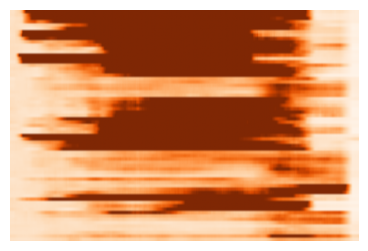

In [4]:
# SEIZURE PROBABILITY HEATMAP VISUALIZATION
# Apply temporal smoothing to probability matrix using moving mean filter
# Remove extra buffer by trimming 220 samples from each end, transpose for proper orientation
plot_mat = sc.ndimage.uniform_filter1d(sz_prob_plot.iloc[220:-220].to_numpy().T, 20, axis=1)

# Create heatmap showing seizure probabilities across channels and time
fig, ax = plt.subplots(figsize=(4.5, 3))
# Use orange colormap with fixed scale (0-5) for consistent visualization
ax.imshow(plot_mat, vmin=0, vmax=5, aspect='auto', cmap='Oranges')

# Remove all axis spines for clean publication-ready appearance
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove tick marks for clean visualization
ax.set_yticks([])
ax.set_xticks([])

# Save as PDF for publication quality
fig.savefig(ospj(figpath, 'figure_2_B.pdf'), bbox_inches='tight')
plt.show()

In [5]:
# LOAD SEIZURE SPREAD DATA FROM HDF5
# Load pre-computed seizure spread analysis and plotting matrices from HDF5 file
# HDF5 format is used for efficient storage of large numerical datasets
with h5py.File(ospj(prodatapath, "sz_spread_and_plot_mat_HUP238.h5"), "r") as f:
    # sz_spread contains timing information for when seizure activity reaches each channel
    sz_spread = pd.DataFrame(f['sz_spread'][:], columns=[c.decode() for c in f['sz_spread_columns'][:]])
    # plot_mat contains processed data ready for visualization
    plot_mat = pd.DataFrame(f['plot_mat'][:], columns=[c.decode() for c in f['plot_mat_columns'][:]])


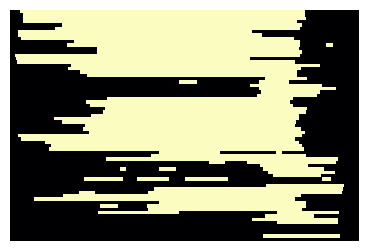

In [6]:
# SEIZURE SPREAD BINARY VISUALIZATION (Figure 2B-iii)
# Create binary heatmap showing seizure involvement across channels and time
fig, ax = plt.subplots(figsize=(4.5, 3))

# Plot binary matrix (0-1 scale) showing seizure presence/absence
# Trim edges to remove artifacts, transpose for proper channel-time orientation
ax.imshow(plot_mat.iloc[220:-220, :].T, vmin=0, vmax=1, aspect='auto', interpolation='none')

# Clean up plot appearance for publication
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_yticks([])  # Remove y-axis labels
ax.set_xticks([])  # Remove x-axis labels

# Save as publication-ready PDF
fig.savefig(ospj(figpath, 'figure_2_Biii.pdf'), bbox_inches='tight')
plt.show()

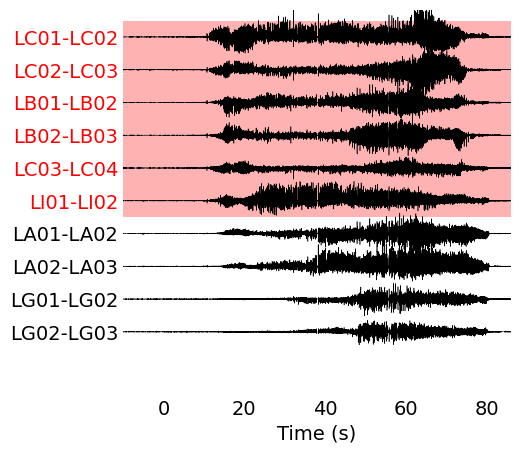

In [7]:
# iEEG TRACES VISUALIZATION (Figure 2B-i)
# Load processed iEEG data for patient HUP238
plot_data = pd.read_pickle(ospj(prodatapath, 'plot_sz_238.pkl'))
plot_time = np.arange(len(plot_data)) / fs  # Convert sample indices to time (seconds)

# Define time window for detailed seizure analysis (100-400 seconds)
plot_inds = (plot_time > 100) & (plot_time < 400)

# Select specific electrode contacts for visualization
# These represent key channels showing seizure onset and propagation
elements = ['LC01-LC02',
            'LC02-LC03',
            'LB01-LB02',
            'LB02-LB03',
            'LC03-LC04',
            'LI01-LI02', 
            'LA01-LA02',
            'LA02-LA03', 
            'LG01-LG02',
            'LG02-LG03']

# Color-code channels based on seizure involvement
# Red channels are primary seizure onset zone, others are non-highlighted
color_idxs = ['red' if c in ['LC01-LC02','LC02-LC03','LC03-LC04','LB01-LB02','LB02-LB03','LI01-LI02'] 
              else None for c in elements]

# Create multi-channel iEEG plot with highlighted seizure onset channels
plot_iEEG_data(plot_data.loc[plot_inds, elements],
               plot_time[plot_inds],
               t_offset=-10,            # Offset for time axis display
               shade_color=color_idxs,  # Background shading for seizure channels
               fig_size=(5, 5),
               empty=True,              # Clean plot style
               colors=color_idxs)       # Line colors for traces

plt.savefig(ospj(figpath, 'figure_2_Bi.pdf'), bbox_inches='tight')

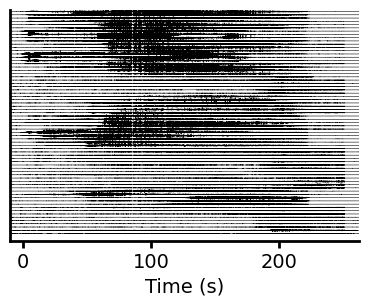

In [8]:
# FULL iEEG OVERVIEW PLOT (Figure 2A)
# Load the same iEEG data for comprehensive view
plot_data = pd.read_pickle(ospj(prodatapath, 'plot_sz_238.pkl'))
plot_time = np.arange(len(plot_data)) / fs

# Use broader time window excluding buffer (110 seconds from start/end)
full_plot_inds = (plot_time > 110) & (plot_time < (max(plot_time) - 110))

# Create comprehensive multi-channel iEEG plot showing all available channels
fig, ax = plot_iEEG_data(plot_data.loc[full_plot_inds, :],  # All channels
                         fs,                                # Sampling frequency for time axis
                         t_offset=-10,                      # Time offset for display
                         fig_size=(4.5, 3),               # Compact figure size
                         empty=False)                       # Standard plot style

# Remove y-axis tick labels for clean appearance
ax.set_yticks([])

# Save as publication figure
fig.savefig(ospj(figpath, 'figure_2_A.pdf'), bbox_inches='tight')
plt.show()

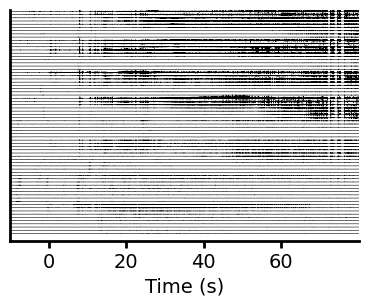

In [9]:
# iEEG PLOT FOR PATIENT HUP235 (Figure 1D)
# Load iEEG data for different patient (HUP235) for comparison analysis
plot_data = pd.read_pickle(ospj(prodatapath, 'plot_sz_235.pkl'))
plot_time = np.arange(len(plot_data)) / fs

# Focus on seizure period (110-200 seconds) for this patient
full_plot_inds = (plot_time > 110) & (plot_time < 200)

# Create iEEG visualization for HUP235 with same formatting as HUP238
fig, ax = plot_iEEG_data(plot_data.loc[full_plot_inds, :],  # All channels for this patient
                         fs,                                # Same sampling frequency
                         t_offset=-10,                      # Consistent time offset
                         fig_size=(4.5, 3),               # Matching figure dimensions
                         empty=False)                       # Standard plot appearance

# Clean y-axis for publication
ax.set_yticks([])

# Save as Figure 1D for comparative analysis
fig.savefig(ospj(figpath, f'figure_1_D.pdf'), bbox_inches='tight')
plt.show()

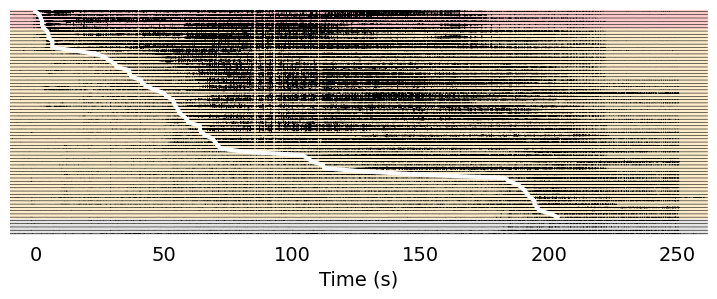

In [10]:
# COMPLEX SEIZURE SPREAD VISUALIZATION WITH ICTAL WAVEFRONT (Figure 3A)
# Load iEEG data for comprehensive seizure spread analysis
plot_data = pd.read_pickle(ospj(prodatapath, 'plot_sz_238.pkl'))
plot_time = np.arange(len(plot_data)) / fs
full_plot_inds = (plot_time > 110) & (plot_time < (max(plot_time) - 110))

# Get all available channels from the filtered data
all_channels = plot_data.loc[full_plot_inds, :].columns

# Organize channels: seizure-involved channels first, then others
other_channels = [ch for ch in all_channels if ch not in sz_spread.columns]
plot_columns = list(sz_spread.columns) + other_channels

# Create hierarchical color scheme for different channel types
# Red: Primary seizure onset zone channels
# Orange: Secondary seizure spread channels 
# Gray: Non-involved channels
color_idxs = [
    'red' if c in ['LC01-LC02','LC02-LC03','LC03-LC04','LB01-LB02','LB02-LB03','LI01-LI02'] 
    else 'orange' for c in sz_spread.columns
] + ['gray'] * len(other_channels)

# Create comprehensive iEEG plot with channel-specific shading
fig, ax = plot_iEEG_data(plot_data.loc[full_plot_inds, :].loc[:, plot_columns],
                         fs,
                         t_offset=-10,           # Time axis offset
                         shade_color=color_idxs, # Background colors for channel groups
                         shade_alpha=0.2,        # Transparent shading
                         fig_size=(9, 3),       # Wide format for many channels
                         empty=True)             # Clean plot style

# Overlay ictal wavefront: white line showing seizure propagation timing
# Extract seizure onset times for each channel from probability data
seizure_mask = sz_spread.to_numpy().flatten()
seizure_times = sz_prob_times[seizure_mask] - 113.5  # Adjust time reference
yticks = ax.get_yticks()

# Plot wavefront progression as white line connecting seizure onset times
ax.plot(seizure_times, yticks[:len(seizure_times)], color='white', linewidth=3)

# Clean up plot for publication
ax.set_yticks([])
fig.savefig(ospj(figpath, 'figure_3_A.pdf'), bbox_inches='tight')
plt.show()

In [11]:
# LOAD HUP235 DATA FOR COMPARATIVE ANALYSIS
# Load iEEG data for patient HUP235 to compare seizure patterns
plot_data = pd.read_pickle(ospj(prodatapath, 'plot_sz_235.pkl'))
plot_time = np.arange(len(plot_data)) / fs

# Load corresponding seizure spread data for HUP235 from HDF5 file
with h5py.File(ospj(prodatapath, "sz_spread_and_plot_mat_HUP235.h5"), "r") as f:
    # Seizure spread timing data for HUP235
    sz_spread = pd.DataFrame(f['sz_spread'][:], columns=[c.decode() for c in f['sz_spread_columns'][:]])
    # Processed plotting matrix for HUP235
    plot_mat = pd.DataFrame(f['plot_mat'][:], columns=[c.decode() for c in f['plot_mat_columns'][:]])

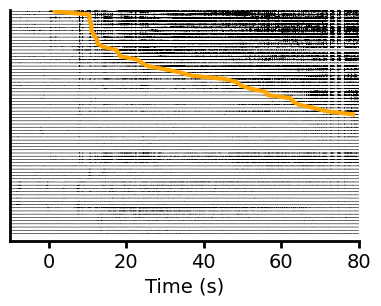

In [12]:
# HUP235 SEIZURE VISUALIZATION WITH ICTAL WAVEFRONT (Figure 1E)
# Define analysis time window for HUP235 (shorter seizure duration)
full_plot_inds = (plot_time > 110) & (plot_time < 200)

# Organize channel order: seizure-involved channels first for clear visualization
other_columns = [col for col in plot_data.columns if col not in sz_spread.columns]
ordered_columns = list(sz_spread.columns) + other_columns

# Apply consistent color scheme: orange for seizure channels, gray for others
color_idxs = ['orange'] * len(sz_spread.columns) + ['gray'] * len(other_columns)

# Create iEEG plot for HUP235 with organized channel layout
fig, ax = plot_iEEG_data(
    plot_data.loc[full_plot_inds, ordered_columns],
    fs,
    t_offset=-10,        # Consistent time offset
    shade_alpha=0.2,     # Subtle background shading
    fig_size=(4.5, 3),   # Compact figure size
    empty=False)         # Standard plot style

# Overlay ictal wavefront for HUP235
# Orange line shows seizure propagation timing across involved channels
seizure_times = sz_prob_times[sz_spread.to_numpy().flatten()] - 116  # Adjusted time reference for HUP235
yticks = ax.get_yticks()
ax.plot(seizure_times, yticks[:len(seizure_times)], color='orange', linewidth=3)

# Customize plot appearance
ax.set_yticks([])           # Remove y-axis labels
ax.set_xlim(-10, 80)        # Focus on relevant time window

# Save as Figure 1E for comparative seizure analysis
fig.savefig(ospj(figpath, 'figure_1_E.pdf'), bbox_inches='tight')
plt.show()

### Stimulation-Induced Seizure Analysis

This section analyzes seizures induced by electrical stimulation, comparing baseline and stimulation conditions to understand how stimulation affects seizure propagation patterns.

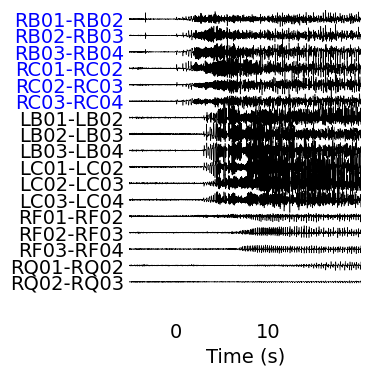

In [13]:
# BASELINE SEIZURE VISUALIZATION (Figure 6A-i)
# Load spontaneous seizure data for patient HUP224
plot_data = pd.read_pickle(ospj(prodatapath, 'plot_sz_224.pkl'))
plot_time = np.arange(len(plot_data)) / fs

# Focus on seizure onset period (115-140 seconds)
full_plot_inds = (plot_time > 115) & (plot_time < 140)

# Define color scheme: blue for stimulation electrode contacts, neutral for others
color_idxs = ['blue'] * 6 + [None] * 11  # First 6 channels highlighted in blue

plot_cols = ['RB01-RB02', 'RB02-RB03', 'RB03-RB04',   
             'RC01-RC02', 'RC02-RC03', 'RC03-RC04',    
             'LB01-LB02', 'LB02-LB03', 'LB03-LB04',    
             'LC01-LC02', 'LC02-LC03', 'LC03-LC04',    
             'RF01-RF02', 'RF02-RF03', 'RF03-RF04',    
             'RQ01-RQ02', 'RQ02-RQ03']                 

# Create baseline seizure visualization
fig, ax = plot_iEEG_data(plot_data.loc[full_plot_inds, plot_cols],
                         fs,
                         colors=color_idxs,    # Color-coded channel highlighting
                         t_offset=-5,          # Adjusted time offset
                         fig_size=(3, 4),     # Vertical layout
                         empty=True)           # Clean plot style

# Save as Figure 6A-i (spontaneous seizure)
fig.savefig(ospj(figpath, 'figure_6_Ai.pdf'), bbox_inches='tight')

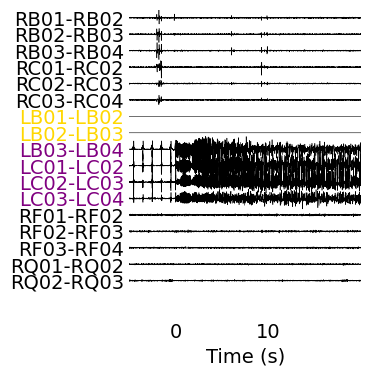

In [14]:
# STIMULATION-MODIFIED SEIZURE VISUALIZATION (Figure 6A-ii)
# Load seizure data during electrical stimulation for HUP224
plot_data = pd.read_pickle(ospj(prodatapath, 'plot_st_sz_224.pkl'))
plot_time = np.arange(len(plot_data)) / fs

# Use same time window as baseline for comparison
full_plot_inds = (plot_time > 115) & (plot_time < 140)

# Zero out specific channels that have stimulation artifacts
plot_data[['LB01-LB02', 'LB02-LB03']] = 0

# Create distinct color scheme to highlight stimulation effects
# Gold: Stimulating channels
# Purple: Stim seizure onset channels
# None: Other channels (neutral)
color_idxs = ([None] * 6 +        # First 6 channels (neutral)
              ['gold'] * 2 +       # Stimulation channels (gold)
              ['purple'] * 4 +     # Seizure onset channels (purple)
              [None] * 5)          # Remaining channels (neutral)

# Create stimulation condition visualization using same channel layout
fig, ax = plot_iEEG_data(plot_data.loc[full_plot_inds, plot_cols],
                         fs,
                         colors=color_idxs,    # Stimulation-specific color scheme
                         t_offset=-5,          # Consistent time offset
                         fig_size=(3, 4),     # Matching figure dimensions
                         empty=True)           # Clean plot style

# Save as Figure 6A-ii
fig.savefig(ospj(figpath, 'figure_6_Aii.pdf'), bbox_inches='tight')